
# Лабаораторная работа №1: Аудио EDA и характеристики сигнала

**Цель:** научиться загружать аудиодатасеты, читать и интерпретировать метаданные, вычислять базовые характеристики аудиосигнала и строить визуализации (waveform, спектр, Mel/Log‑Mel).  
**Формат:** заполнить `TODO`‑ячейки. Ячейки с `raise NotImplementedError` необходимо заменить вашим кодом.

**Требования по оформлению графиков:** используйте `matplotlib` (без seaborn), один график на фигуру, не задавайте кастомные цвета.

**Зависимости:** `datasets[audio]`, `librosa`, `numpy`, `matplotlib`, `soundfile`, `tqdm`.


In [1]:
pip install -q datasets[audio] librosa soundfile matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
t

In [2]:

# === Установка и импорт (при необходимости раскомментируйте установки) ===
# !pip install -q datasets[audio] librosa soundfile matplotlib numpy tqdm

import os, json, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset, Audio
import librosa, librosa.display
import soundfile as sf

import warnings; warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED); np.random.seed(SEED)



## Задание 1. Выбор и загрузка датасета(ов)

**Варианты:**
- Речь (например, `PolyAI/minds14`, любая локаль).
- Звуки окружения (любой датасет на HF Hub или локальная папка WAV/FLAC).

**Что сделать:**
1. Указать идентификатор/путь датасета.
2. Загрузить сплит (например, `train` или подвыборку).
3. Показать структуру фич и пример записи.


In [3]:

# TODO-1.1: укажите идентификатор (или оставьте None для локальной загрузки)
DATASET_ID = "PolyAI/minds14"   # замените при необходимости
DATASET_CONFIG = "en-AU"        # например: en-AU, ru-RU и т.д. (или None)
DATASET_SPLIT = "train"         # можно взять 'train[:200]' для подвыборки

# TODO-1.2: загрузка датасета через 🤗 Datasets
try:
    ds = load_dataset(DATASET_ID, name=DATASET_CONFIG, split=DATASET_SPLIT)
except Exception as e:
    print("Не удалось загрузить датасет через load_dataset:", e)
    ds = None  # Реализуйте локальную загрузку ниже при необходимости

# TODO-1.3 (опц.): локальная загрузка как Dataset из списка путей/метаданных
# Подсказка: соберите dict c полями 'path' и 'audio' (array, sampling_rate)
# raise NotImplementedError("Реализуйте локальную загрузку при необходимости.")


README.md: 0.00B [00:00, ?B/s]

en-AU/train-00000-of-00001.parquet:   0%|          | 0.00/37.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/654 [00:00<?, ? examples/s]

In [4]:

# TODO-1.4: выведите схему фич и пример
def preview(ds, n=1):
    if ds is None:
        print("Dataset is None")
        return
    print(ds)
    print("Пример:")
    print(ds[0])

preview(ds, n=1)


Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})
Пример:
{'path': 'en-AU~PAY_BILL/response_4.wav', 'audio': {'path': 'response_4.wav', 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
        0.00024414,  0.0012207 ]), 'sampling_rate': 8000}, 'transcription': 'I would like to pay my electricity bill using my card can you please assist', 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist', 'intent_class': 13, 'lang_id': 2}



## Задание 2. Базовые характеристики аудиосигнала

**Что посчитать для N примеров:**
- Частота дискретизации (SR), длительность (с), количество каналов.
- Пиковый уровень (max |x|), RMS‑уровень, оценка динамического диапазона (приближенно).
- Коэффициент клиппинга (% сэмплов с |x|≈1.0 при float или на границе int).
- Zero‑Crossing Rate (ZCR), спектральный центроид и полосa (bandwidth).
- (Опционально) Оценка SNR при простой модели шума (на ваш выбор).

**Вывести:**
- Сводную таблицу (словари/списки), а также агрегаты: mean/median/p95.


In [5]:

# TODO-2.1: реализуйте функции вычисления характеристик
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1: return 1
    # TODO: если стерео (C x T или T x C) — обработайте
    raise NotImplementedError

def peak_level(arr: np.ndarray) -> float:
    """Пиковый уровень max |x| для float в [-1, 1]."""
    # TODO: верните float
    raise NotImplementedError

def rms_level(arr: np.ndarray) -> float:
    """RMS-уровень сигнала."""
    # TODO: np.sqrt(np.mean(arr**2))
    raise NotImplementedError

def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    """Доля сэмплов близких к клиппингу (|x| >= thr)."""
    # TODO: верните долю
    raise NotImplementedError

def zero_crossing_rate(arr: np.ndarray) -> float:
    """Оценка ZCR (число пересечений нуля / длина)."""
    # TODO: используйте np.sign и подсчёт смен знака
    raise NotImplementedError

def spectral_stats(arr: np.ndarray, sr: int):
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    # TODO: librosa.feature.spectral_centroid / spectral_bandwidth
    raise NotImplementedError

def duration_seconds(arr: np.ndarray, sr: int) -> float:
    return len(arr) / float(sr)


**Выполнение**

In [6]:
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1:
        return 1
    elif arr.ndim == 2:
        # Если форма (C, T) или (T, C), выбираем меньшее как каналы
        return arr.shape[0] if arr.shape[0] <= arr.shape[1] else arr.shape[1]
    else:
        raise ValueError(f"Unsupported array shape: {arr.shape}")

def peak_level(arr: np.ndarray) -> float:
    """Пиковый уровень max |x| для float в диапазоне [-1, 1]."""
    return float(np.max(np.abs(arr)))

def rms_level(arr: np.ndarray) -> float:
    """RMS-уровень сигнала."""
    return float(np.sqrt(np.mean(arr**2)))

def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    """Доля сэмплов близких к клиппингу (|x| >= thr)."""
    return float(np.mean(np.abs(arr) >= thr))

def zero_crossing_rate(arr: np.ndarray) -> float:
    """Оценка ZCR (число пересечений нуля / длина)."""
    # np.diff(np.sign(arr)) != 0 означает смену знака
    zc = np.sum(np.diff(np.sign(arr)) != 0)
    return float(zc / len(arr))

def spectral_stats(arr: np.ndarray, sr: int):
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    if arr.ndim > 1:  # моно для спектра
        arr = arr.mean(axis=0)
    centroid = librosa.feature.spectral_centroid(y=arr, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=arr, sr=sr)
    return {
        "centroid": float(np.mean(centroid)),
        "bandwidth": float(np.mean(bandwidth))
    }

def duration_seconds(arr: np.ndarray, sr: int) -> float:
    return len(arr) / float(sr)


In [7]:

# TODO-2.2: пройдите по подвыборке датасета и соберите метрики
N = 200  # размер подвыборки для оценки
metrics = []

if ds is not None:
    idxs = np.random.choice(len(ds), size=min(N, len(ds)), replace=False)
    for i in tqdm(idxs, desc="Computing metrics"):
        ex = ds[int(i)]
        aud = ex.get("audio", {})
        arr, sr = aud.get("array"), aud.get("sampling_rate")
        if arr is None or sr is None:
            continue
        # Если многоканальный — приведите к моно для метрик или учитывайте каналы отдельно
        # TODO: при необходимости to_mono
        m = {
            "sr": sr,
            "dur_s": duration_seconds(arr, sr),
            "channels": num_channels(arr),
            "peak": peak_level(arr),
            "rms": rms_level(arr),
            "clip_ratio": clipping_ratio(arr),
            "zcr": zero_crossing_rate(arr),
        }
        sc = spectral_stats(arr, sr)  # ожидается dict с ключами, например, 'centroid', 'bandwidth'
        if isinstance(sc, dict): m.update(sc)
        metrics.append(m)

metrics[:3]  # просмотр первых строк


Computing metrics: 100%|██████████| 200/200 [00:05<00:00, 36.35it/s]


[{'sr': 8000,
  'dur_s': 6.130125,
  'channels': 1,
  'peak': 0.8553466796875,
  'rms': 0.11050476662861407,
  'clip_ratio': 0.0,
  'zcr': 0.3334556799412736,
  'centroid': 1356.0115038847525,
  'bandwidth': 893.6857250843273},
 {'sr': 8000,
  'dur_s': 19.285375,
  'channels': 1,
  'peak': 0.6365966796875,
  'rms': 0.07038895215030415,
  'clip_ratio': 0.0,
  'zcr': 0.193754334566997,
  'centroid': 903.2753588918177,
  'bandwidth': 824.9591180193216},
 {'sr': 8000,
  'dur_s': 6.62,
  'channels': 1,
  'peak': 0.3162841796875,
  'rms': 0.02426519857680162,
  'clip_ratio': 0.0,
  'zcr': 0.26334969788519635,
  'centroid': 1352.84673486297,
  'bandwidth': 1027.840035877024}]

**1. Частота дискретизации (sr)**
Суть: Сколько раз в секунду аналоговый звуковой сигнал "измеряется" для преобразования в цифровой формат. Измеряется в Герцах (Гц).

Что показывает: Определяет верхнюю частоту, которую можно представить в цифровом сигнале (по теореме Котельникова, это половина частоты дискретизации). Для речи обычно используется 8 кГц (как в датасете), этого достаточно для разборчивости (частоты до 4 кГц). Для музыки нужны более высокие частоты (44.1 кГц и выше).

В нашем случае: sr = 8000 Гц. Это стандарт для телефонной речи.

**2. Длительность (dur_s)**
Суть: Просто длина аудиозаписи в секундах. Вычисляется как количество_сэмплов / частота_дискретизации.

Что показывает: Прямолинейная метрика. Помогает оценить объем данных и выявить выбросы (очень короткие или очень длинные записи).

В нашем случае: Средняя длительность ~8.18 сек, но 95-й процентиль ~19.9 сек, что говорит о наличии заметного количества более длинных записей (медиана всего 6.19 сек).

**3. Количество каналов (channels)**
Суть: Число независимых аудиодорожек в файле (например, 1 - моно, 2 - стерео).

Что показывает: Для речи обычно используется моно-запись. Стерео может потребовать преобразования к моно для упрощения анализа.

В нашем случае: Все записи моно (channels = 1), что типично для подобных датасетов.

**4. Пиковый уровень (peak)**
Суть: Максимальное абсолютное значение амплитуды сигнала. Для цифрового аудио обычно нормировано в диапазон [-1.0, 1.0].

Что показывает: Насколько "громким" может быть сигнал в самый пиковый момент. Значение, близкое к 1.0, говорит о высокой громкости, но если оно равно 1.0, это может указывать на клиппинг (искажения).

В нашем случае: Средний пик ~0.57, что далеко от 1.0. Это хорошо — сигналы не перегружены.

**5. RMS-уровень (rms)**
Суть: Root Mean Square (СКЗ) — среднеквадратичное значение амплитуды. Вычисляется как sqrt(mean(arr**2)).

Что показывает: Энергия или громкость сигнала в среднем. В отличие от пикового уровня, RMS лучше отражает воспринимаемую громкость, так как учитывает все значения сигнала, а не только пики.

В нашем случае: Средний RMS ~0.054. Это довольно низкое значение, что характерно для речи, где много тихих пауз между словами.

**6. Коэффициент клиппинга (clip_ratio)**
Суть: Доля сэмплов, амплитуда которых достигла максимума (|x| >= threshold, где threshold обычно близок к 1.0, например, 0.999).

Что показывает: Наличие искажений (клиппинга), возникающих когда сигнал превышает динамический диапазон оборудования. Ненулевое значение — это плохо.

В вашем случае: clip_ratio = 0.0 для всех примеров. Отличный результат, означает высокое качество записи.

**7. Zero-Crossing Rate (ZCR) (zcr)**
Суть: Скорость пересечения нуля — количество раз в секунду, когда сигнал меняет знак (переходит от положительного к отрицательному и наоборот). Нормируется на длину сигнала.

Что показывает:

Высокий ZCR: Характерен для шумных или шипящих звуков (например, звук "с"), а также для тишины (шум с частотой, близкой к частоте дискретизации).

Низкий ZCR: Характерен для гласных звуков и тональных сигналов.

Применение: Простой, но эффективный признак для классификации звуков/речи, обнаружения активности речи (VAD).

В нашем случае: Средний ZCR ~0.27. Это типичное значение для речи.

**8. Спектральный центроид (centroid)**
Суть: "Центр масс" спектра. Усредненная частота, взвешенная по энергии спектральных компонент. Измеряется в Герцах (Гц).

Что показывает:

Высокий центроид: Спектр смещен в сторону высоких частот (звонкие, шипящие звуки).

Низкий центроид: Спектр смещен в сторону низких частот (глухие звуки, барабаны).

Интерпретация: Часто correlates с "яркостью" или "резкостью" звука.

В нашем случае: Средний центроид ~1319 Гц. Это соответствует основным частотам человеческой речи.

**9. Спектральная полоса (bandwidth)**
Суть: Ширина полосы частот вокруг спектрального центроида, в которой сосредоточена основная энергия сигнала. По сути, показывает, насколько "размазан" спектр.

Что показывает:

Широкая полоса: Сигнал содержит много разных частот (шум, фрикативные согласные like "ш", "ф").

Узкая полоса: Энергия сконцентрирована вокруг узкого набора частот (тональные звуки, гласные).

In [8]:

# TODO-2.3: агрегируйте метрики и выведите сводку (mean/median/p95)
import numpy as np

def agg(values):
    if not values: return {"mean": None, "median": None, "p95": None}
    arr = np.array(values, dtype=float)
    return {"mean": float(np.mean(arr)), "median": float(np.median(arr)), "p95": float(np.percentile(arr, 95))}

def summarize(metrics):
    keys = [k for k in metrics[0].keys() if isinstance(metrics[0][k], (int, float))]
    summary = {}
    for k in keys:
        summary[k] = agg([m[k] for m in metrics if m.get(k) is not None])
    return summary

if metrics:
    summary = summarize(metrics)
    print(json.dumps(summary, indent=2, ensure_ascii=False))
else:
    print("Нет метрик для сводки — проверьте загрузку/вычисления.")


{
  "sr": {
    "mean": 8000.0,
    "median": 8000.0,
    "p95": 8000.0
  },
  "dur_s": {
    "mean": 8.31026875,
    "median": 6.315250000000001,
    "p95": 19.298106249999993
  },
  "channels": {
    "mean": 1.0,
    "median": 1.0,
    "p95": 1.0
  },
  "peak": {
    "mean": 0.589521484375,
    "median": 0.6053466796875,
    "p95": 0.9506591796874995
  },
  "rms": {
    "mean": 0.05825574031868222,
    "median": 0.05396815424434677,
    "p95": 0.11829728493151118
  },
  "clip_ratio": {
    "mean": 0.0,
    "median": 0.0,
    "p95": 0.0
  },
  "zcr": {
    "mean": 0.27278230643939955,
    "median": 0.2762841174309937,
    "p95": 0.36552465210584323
  },
  "centroid": {
    "mean": 1298.3448414762831,
    "median": 1289.7793220797334,
    "p95": 1635.3930619347818
  },
  "bandwidth": {
    "mean": 955.9951620691436,
    "median": 970.6989891025305,
    "p95": 1083.5113173300106
  }
}



## Задание 3. Визуализация: waveform, спектр, Mel/Log‑Mel

**Что сделать:**
1. Построить waveform для нескольких примеров (ось x — время, y — амплитуда).
2. STFT‑спектрограмму в dB (логарифмическая шкала по амплитуде).
3. Mel‑спектрограмму и Log‑Mel при разных параметрах (`n_fft`, `hop_length`, `n_mels`, `fmax`, `htk/slaney`).
4. Сравнить как минимум 3 конфигурации и описать наблюдения в тексте.


In [9]:

# TODO-3.1: вспомогательные функции визуализации
def plot_waveform(arr, sr, title="Waveform"):
    plt.figure()
    librosa.display.waveshow(arr, sr=sr)
    plt.title(title); plt.xlabel("Time"); plt.ylabel("Amplitude"); plt.show()

def plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram (dB)"):
    import numpy as np
    D = librosa.stft(arr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title); plt.colorbar(); plt.show()

def plot_mel_logmel(arr, sr, n_fft=2048, hop_length=512, n_mels=80, fmax=None, htk=False, title_prefix="Mel"):
    import numpy as np
    mel = librosa.feature.melspectrogram(y=arr, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, htk=htk)
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    librosa.display.specshow(logmel, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.title(f"{title_prefix}: log-Mel (n_mels={n_mels}, htk={htk})"); plt.colorbar(); plt.show()
    return mel, logmel


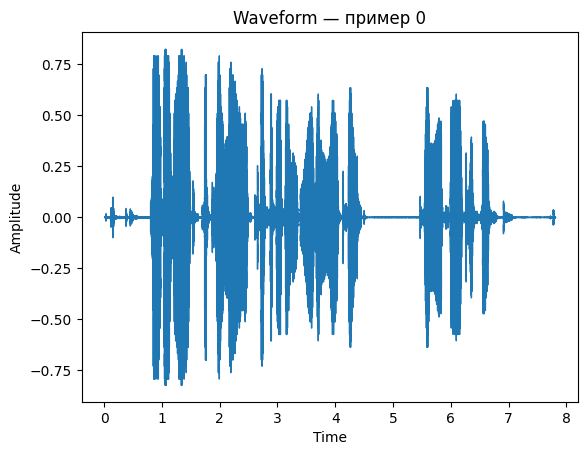

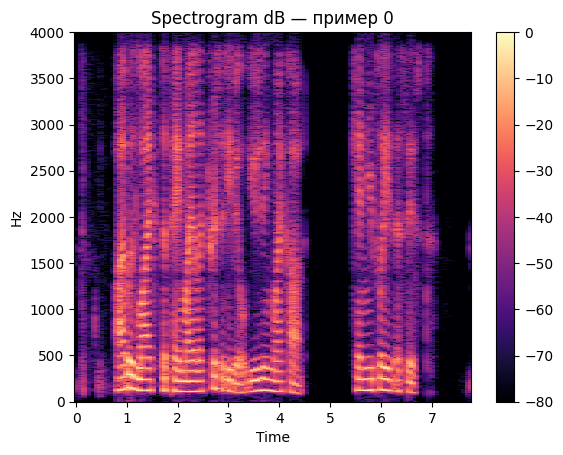

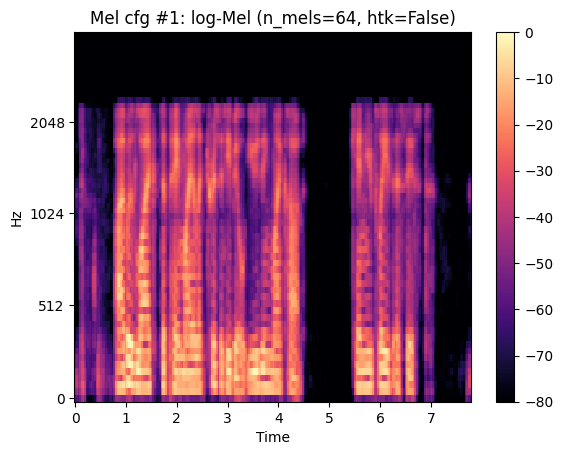

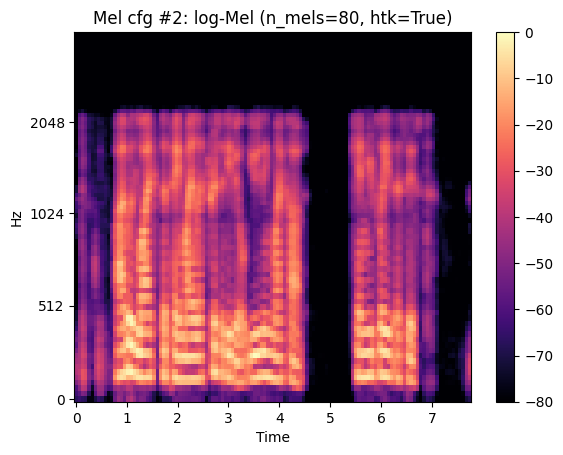

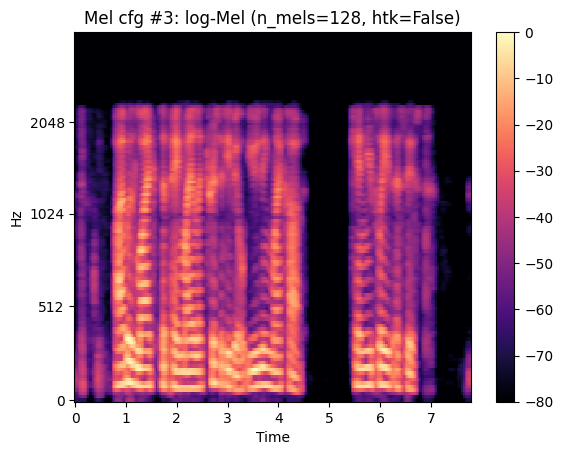

In [10]:

# TODO-3.2: выберите 1-2 примера и постройте все типы визуализаций
if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
    plot_waveform(arr, sr, title="Waveform — пример 0")
    plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram dB — пример 0")
    # Mel/Log‑Mel: сравнение конфигураций
    cfgs = [
        dict(n_fft=1024, hop_length=256, n_mels=64, fmax=8000, htk=False),
        dict(n_fft=2048, hop_length=512, n_mels=80, fmax=8000, htk=True),
        dict(n_fft=2048, hop_length=256, n_mels=128, fmax=8000, htk=False),
    ]
    for i, cfg in enumerate(cfgs):
        plot_mel_logmel(arr, sr, **cfg, title_prefix=f"Mel cfg #{i+1}")
else:
    print("Датасет пуст или не загружен.")


**ДОП эксперимент**

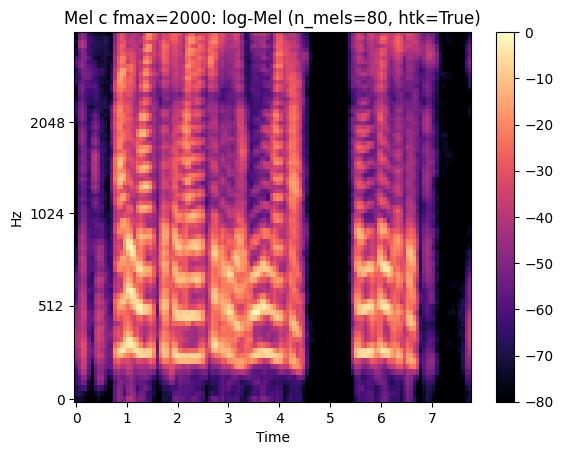

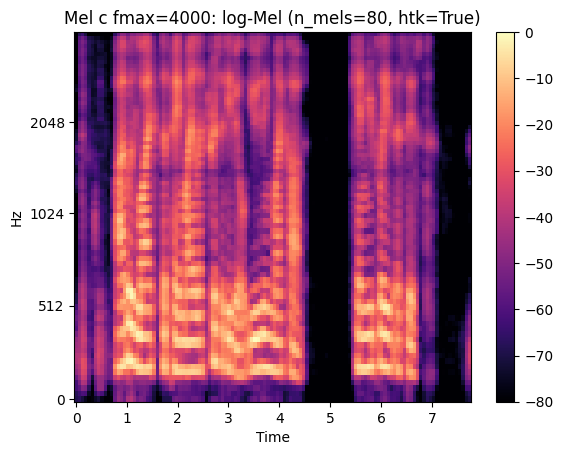

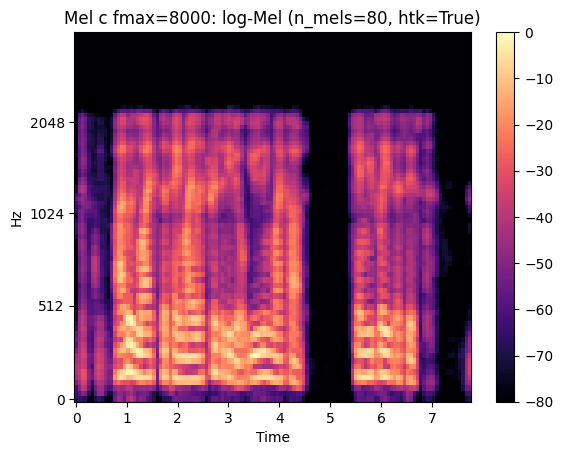

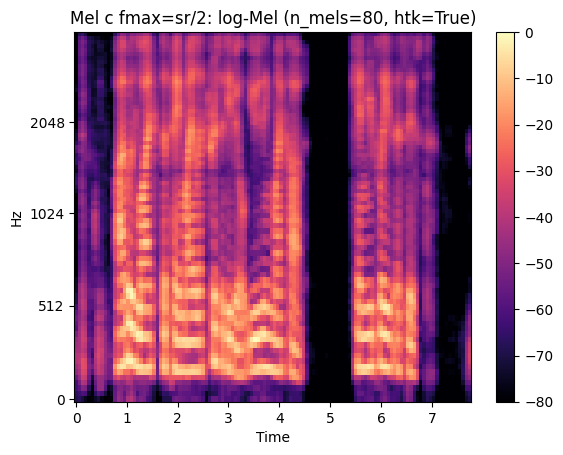

In [11]:
# --- Дополнительный эксперимент: влияние fmax на Mel/Log-Mel ---
if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']

    fmax_values = [2000, 4000, 8000, None]  # разные верхние частоты (None = sr/2)
    for i, fmax_val in enumerate(fmax_values):
        plot_mel_logmel(
            arr, sr,
            n_fft=2048,
            hop_length=512,
            n_mels=80,
            fmax=fmax_val,
            htk=True,
            title_prefix=f"Mel с fmax={fmax_val if fmax_val else 'sr/2'}"
        )



## Задание 4. Передискретизация и сравнение (resampling)

**Что сделать:**
1. Передискретизировать сигнал до 16 kHz (если исходно другой SR) и сравнить waveform/спектры до/после.
2. Посчитать Nyquist‑частоту для обеих SR и обсудить, какие частоты потенциально теряются.
3. Оценить влияние `hop_length` при фиксированном `n_fft` на временное/частотное разрешение.


In [12]:

# TODO-4.1: ресемплинг и сравнение
TARGET_SR = 16_000

def resample(arr, sr, target_sr=TARGET_SR):
    if sr == target_sr:
        return arr, sr
    # TODO: реализуйте через librosa.resample
    raise NotImplementedError

def nyquist(sr):
    return sr / 2.0

if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']
    arr2, sr2 = resample(arr, sr, TARGET_SR)
    # Визуальное сравнение
    plot_waveform(arr, sr, title=f"Waveform SR={sr}")
    plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
    plot_spectrogram_db(arr, sr, title=f"Spec dB SR={sr}")
    plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")
    print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")


NotImplementedError: 

**Выполнение**

In [ ]:
import numpy as np
import librosa

TARGET_SR = 16_000

def resample(arr, sr, target_sr=TARGET_SR):
    """Пересэмплирование аудио до target_sr через librosa.resample.
       Возвращает массив и новый sr.
       Если стерео, пересэмплирует каждый канал отдельно.
    """
    if sr == target_sr:
        return arr, sr
    if arr.ndim == 1:
        arr_res = librosa.resample(arr, orig_sr=sr, target_sr=target_sr)
    else:
        # Определяем, где каналы
        if arr.shape[0] <= arr.shape[1]:  # C x T
            arr_res = np.stack([librosa.resample(ch, orig_sr=sr, target_sr=target_sr) for ch in arr])
        else:  # T x C
            arr_res = np.stack([librosa.resample(arr[:, ch], orig_sr=sr, target_sr=target_sr) for ch in range(arr.shape[1])], axis=1)
    return arr_res, target_sr

def nyquist(sr):
    return sr / 2.0

# Проверка и визуализация
if ds is not None and len(ds) > 0:
    ex = ds[0]
    arr, sr = ex['audio']['array'], ex['audio']['sampling_rate']

    # Приведение стерео к моно для визуализации
    if arr.ndim > 1:
        arr_mono = arr.mean(axis=0) if arr.shape[0] <= arr.shape[1] else arr.mean(axis=1)
    else:
        arr_mono = arr

    arr2, sr2 = resample(arr_mono, sr, TARGET_SR)

    # Визуальное сравнение
    plot_waveform(arr_mono, sr, title=f"Waveform SR={sr}")
    plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
    plot_spectrogram_db(arr_mono, sr, title=f"Spec dB SR={sr}")
    plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")

    print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")


In [ ]:
# Анализ влияния hop_length
n_fft = 2048  # фиксированный размер окна

# Сравним разные hop_length для одного сигнала
hop_lengths = [128, 256, 512, 1024]

plt.figure(figsize=(15, 10))
for i, hop_len in enumerate(hop_lengths, 1):
    plt.subplot(2, 2, i)
    
    # Строим спектрограмму
    D = librosa.stft(arr2, n_fft=n_fft, hop_length=hop_len)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    librosa.display.specshow(S_db, sr=sr2, hop_length=hop_len, 
                            x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'hop_length = {hop_len}\nВременное разрешение: {1000*hop_len/sr2:.1f}ms')
    
plt.tight_layout()
plt.show()

# Расчет разрешений
print("\n=== Влияние hop_length при n_fft=2048 ===")
for hop_len in hop_lengths:
    time_resolution = hop_len / sr2 * 1000  # мс
    freq_resolution = sr2 / n_fft  # Гц
    print(f"hop_length={hop_len}: Временное разрешение = {time_resolution:.1f}ms, "
          f"Частотное разрешение = {freq_resolution:.2f}Hz")

**Выводы**
Передискретизация с 8 кГц до 16 кГц для речевых данных часто бессмысленна - высокие частоты уже потеряны

Nyquist-частота критически важна при записи - определяет максимальную сохраняемую частоту

Выбор hop_length - это компромисс:

Малый hop_length: лучшее временное разрешение (точнее видно изменения), но больше вычислений

Большой hop_length: худшее временное разрешение (размытие во времени), но быстрее вычисления

Для речи обычно используют hop_length=256 при sr=16кГц - хороший баланс между разрешением и производительностью.


## Задание 5. Dataset‑level EDA

**Что сделать:**
1. Построить распределения длительностей, SR, пиковых уровней (гистограммы).
2. (Если есть метки классов) — подсчитать число примеров по классам.
3. Сформировать короткие выводы о качестве сырого датасета (наличие очень коротких/длинных записей, клиппинг и пр.).


In [ ]:

# TODO-5.1: гистограммы и распределения
def hist(values, bins=30, title="Histogram", xlabel="value"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel("count"); plt.show()

if metrics:
    hist([m['dur_s'] for m in metrics if m.get('dur_s') is not None], title="Duration (s)", xlabel="seconds")
    hist([m['sr'] for m in metrics if m.get('sr') is not None], title="Sampling Rate", xlabel="Hz")
    hist([m['peak'] for m in metrics if m.get('peak') is not None], title="Peak level", xlabel="abs max")


**Выполнение**

In [ ]:
# TODO-5.1: гистограммы и распределения
def hist(values, bins=30, title="Histogram", xlabel="value"):
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.show()

if metrics:
    # --- Гистограммы ---
    hist([m['dur_s'] for m in metrics if m.get('dur_s') is not None],
         title="Duration (s)", xlabel="seconds")
    hist([m['sr'] for m in metrics if m.get('sr') is not None],
         title="Sampling Rate", xlabel="Hz")
    hist([m['peak'] for m in metrics if m.get('peak') is not None],
         title="Peak level", xlabel="abs max")

    # --- Распределение по классам ---
    from collections import Counter
    import matplotlib.pyplot as plt

    if ds is not None:
        try:
            counts = Counter([y for _, y in ds])  
            if counts:
                plt.figure()
                plt.bar(counts.keys(), counts.values())
                plt.title("Class distribution")
                plt.xlabel("class")
                plt.ylabel("count")
                plt.show()
        except Exception:
            print("Не удалось построить распределение по классам (нет меток?).")

    # --- Короткий отчёт о качестве датасета ---
    import numpy as np

    durs = [m['dur_s'] for m in metrics if m.get('dur_s') is not None]
    peaks = [m['peak'] for m in metrics if m.get('peak') is not None]

    print("=== Dataset quality report ===")
    print(f"Всего файлов: {len(metrics)}")
    if durs:
        print(f"Средняя длительность: {np.mean(durs):.2f} сек "
              f"(min={np.min(durs):.2f}, max={np.max(durs):.2f})")
    if peaks:
        print(f"Средний пик: {np.mean(peaks):.3f}, max={np.max(peaks):.3f}")

    # эвристики
    short = sum(d < 1.0 for d in durs)
    long = sum(d > 30.0 for d in durs)
    clipped = sum(p >= 1.0 for p in peaks)

    print(f"Очень короткие записи (<1с): {short}")
    print(f"Очень длинные записи (>30с): {long}")
    print(f"Записи с возможным клиппингом (peak>=1.0): {clipped}")


Всего файлов: 200 → датасет небольшой

Длительности: в среднем ~8.3 с, диапазон 1.95 – 30.63 с → записи в основном средней длины, есть одна очень длинная (выброс).

Коротких записей (<1 с): 0 → значит, откровенно «обрезков» нет.

Пики: средний 0.59, максимальный 0.98 → клиппинга нет, нормализация скорее всего не требуется.

Дисбаланс по классам: меток нет, поэтому распределение построить нельзя.